# Human Emotion Recognition

### Personal Project

Nina Cardenas

## 0. Initialization and setup

In [10]:
!pip install plotly
!pip install matplotlib
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install -U scikit-learn
!pip install scipy

In [11]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
import tensorflow as tf
import sklearn.model_selection as model_selection
import keras
import scipy
from keras.preprocessing.image import ImageDataGenerator

## 1. Data Collection and Analysis

In [12]:
raw_df = pd.read_csv("fer2013.csv")
labels = ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]
labels_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

In [13]:
raw_df.shape

(35887, 3)

In [14]:
raw_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### 1.1 Analyzing class distribution

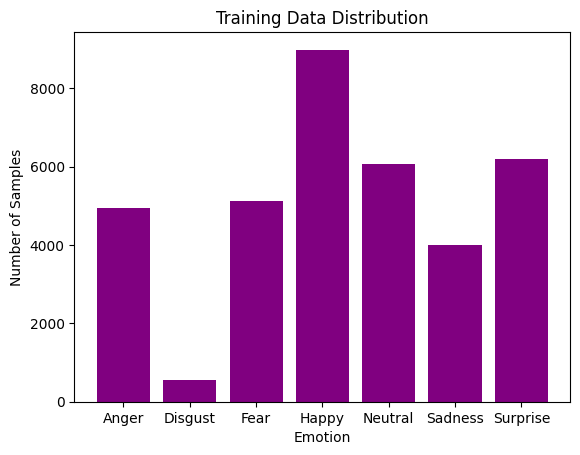

In [15]:
plt.title("Training Data Distribution")
plt.bar(labels, [list(raw_df['emotion']).count(i) for i in np.unique(raw_df['emotion'])], color="purple")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")

plt.show()

### 1.2 Class imbalance

In [16]:
occ = np.bincount(raw_df['emotion'])
total = np.sum(occ)
disgust = np.amin(occ)
happy = np.amax(occ)
print('Total classes: {}\nTotal samples: {}\nDisgust: {} ({:.2f}% of total)\nHappy: {} ({:.2f}% of total)\n'.format(len(occ),
    total, disgust, 100 * disgust / total,happy,100*happy/total))

Total classes: 7
Total samples: 35887
Disgust: 547 (1.52% of total)
Happy: 8989 (25.05% of total)



## 2. Preprocessing

In [43]:
# shuffle dataset
df = raw_df.sample(frac=1)#,random_state=1)
df

,emotion,pixels,Usage
5508,4,123 108 117 149 156 168 136 134 143 127 123 13...,Training
19282,3,51 51 52 49 70 112 111 115 119 106 110 120 86 ...,Training
6612,5,183 183 191 171 128 160 150 170 186 154 183 16...,Training
30297,3,129 128 127 125 124 123 122 123 77 18 18 18 19...,PublicTest
33634,3,214 251 254 252 245 231 237 221 195 195 174 17...,PrivateTest
...,...,...,...
773,2,216 216 213 207 212 112 5 14 14 18 22 42 93 11...,Training
5244,0,167 170 170 169 155 162 184 187 187 200 214 20...,Training
8847,3,17 18 11 63 155 161 172 185 176 179 184 185 18...,Training
5516,4,129 88 93 128 157 181 202 213 210 210 215 212 ...,Training


In [44]:
# one hot enconding
onehot_labels = ks.utils.to_categorical(df[['emotion']], num_classes=7)

In [45]:
#train = df[df['Usage'] == 'Training]

In [46]:
data = np.float32(df['pixels'].astype('str').str.split(" ").tolist())
data.shape

(35887, 2304)

In [47]:
np.amax(data) #maximum value in unscaled data

255.0

In [48]:
np.amin(data) # minimum value in unscaled data

0.0

In [49]:
data = data / 255.0
data

array([[0.48235294, 0.42352942, 0.45882353, ..., 0.81960785, 0.8784314 ,
        0.9019608 ],
       [0.2       , 0.2       , 0.20392157, ..., 0.27058825, 0.3372549 ,
        0.30588236],
       [0.7176471 , 0.7176471 , 0.7490196 , ..., 0.9843137 , 0.9882353 ,
        0.9882353 ],
       ...,
       [0.06666667, 0.07058824, 0.04313726, ..., 0.38039216, 0.36078432,
        0.34509805],
       [0.5058824 , 0.34509805, 0.3647059 , ..., 0.03137255, 0.02352941,
        0.02352941],
       [0.09411765, 0.07843138, 0.06666667, ..., 0.22745098, 0.23137255,
        0.23529412]], dtype=float32)

In [50]:
from math import sqrt
sqrt(2304)

48.0

In [51]:
data = data.reshape((35887,48,48,1))

In [52]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, onehot_labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [53]:
datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             zoom_range = 0.2)
valgen = ImageDataGenerator(width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            horizontal_flip = True,
                            zoom_range = 0.2) 

In [54]:
datagen.fit(X_train)
valgen.fit(X_val)

In [55]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

## 3. ConvNet Model

In [32]:
# defining cnn model layers
model = keras.Sequential([
    # layer 1 (conv2d)
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', kernel_initializer="random_normal", input_shape=(48, 48, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    # block 2 (conv2d)
    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # block 3 (conv2d)
    keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # block 4 (conv2d)
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # block 5 (conv2d)
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
     # flattening
    keras.layers.Flatten(),
    
    # layer 5 (dense)
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # layer 6 (dense)
    keras.layers.Dense(7, activation='softmax')
])

In [33]:
# printing model summary
model.summary()

# compiling model using adam optimizer and categorical ce loss function
# only metric analyzed is accuracy
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,decay=1e-6), #'adam'
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
model.fit(train_generator,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=val_generator)

Epoch 1/20
455/455 [==============================] - 23s 51ms/step - loss: 1.2885 - accuracy: 0.5846 - val_loss: 1.2919 - val_accuracy: 0.6043
Epoch 2/20
455/455 [==============================] - 23s 50ms/step - loss: 1.2533 - accuracy: 0.5986 - val_loss: 1.2750 - val_accuracy: 0.5768
Epoch 3/20
455/455 [==============================] - 23s 51ms/step - loss: 1.2184 - accuracy: 0.6070 - val_loss: 1.2148 - val_accuracy: 0.5994
Epoch 4/20
455/455 [==============================] - 23s 51ms/step - loss: 1.2048 - accuracy: 0.6023 - val_loss: 1.2392 - val_accuracy: 0.5820
Epoch 5/20
455/455 [==============================] - 23s 51ms/step - loss: 1.1674 - accuracy: 0.6101 - val_loss: 1.1957 - val_accuracy: 0.5916
Epoch 6/20
270/455 [================>.............] - ETA: 8s - loss: 1.1484 - accuracy: 0.6162

In [37]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
model.history.history['val_accuracy']

[0.24365325272083282,
 0.2888544797897339,
 0.34458205103874207,
 0.36160990595817566,
 0.3767801821231842,
 0.46315789222717285,
 0.4962848424911499,
 0.5071207284927368,
 0.47027865052223206,
 0.4696594476699829,
 0.5130031108856201,
 0.5272445678710938,
 0.4990712106227875,
 0.478018581867218,
 0.5572755336761475,
 0.5356037020683289,
 0.5560371279716492,
 0.5730650424957275,
 0.5712074637413025,
 0.5721362233161926]

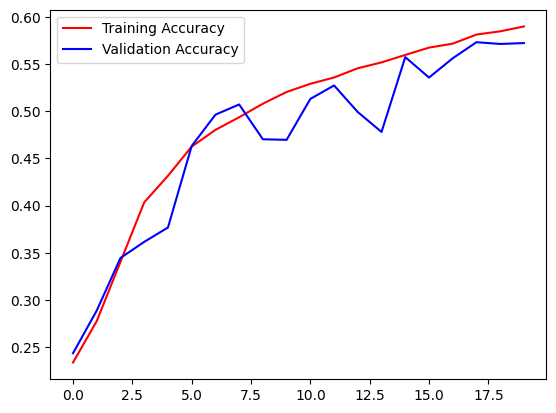

In [39]:
plt.plot(model.history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(model.history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

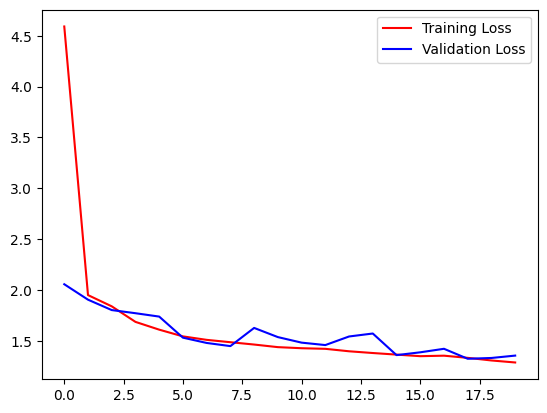

In [40]:
plt.plot(model.history.history["loss"],'r', label="Training Loss")
plt.plot(model.history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test,batch_size=128)

print('Test accuracy:', test_acc)
print('Test loss: ', test_loss)

29/29 [==============================] - 1s 41ms/step - loss: 1.3276 - accuracy: 0.5720
Test accuracy: 0.5720256567001343
Test loss:  1.327579379081726


In [42]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model and model weights to disk.")

Saved model and model weights to disk.
